
#### 1️⃣Problem Statement
The numerical example is a reliability-based design optimization (RBDO) problem involving two probabilistic constraints and two random design variables.

This problem has two independent normally distributed random variables and two probabilistic constraints, which are detailed as follows:
- **design variable**: $d = [d_1, d_2]^T$
- **target function**: minimize $f(d) = (d_1 - 3.7)^2 + (d_2 - 4)^2$
- **constraint condition**:
  - $P(g_1(X) < 0) \leq \Phi(-\beta_1^t)$
  - $P(g_2(X) < 0) \leq \Phi(-\beta_2^t)$
  - where:
    - $g_1(X) = -X_1 \sin(4X_1) - 1.1X_2 \sin(2X_2)$
    - $g_2(X) = X_1 + X_2 - 3$
- **range of variable**:
  - $0.0 \leq \mu_1 \leq 3.7$
  - $0.0 \leq \mu_2 \leq 4.0$
- **variable distribution**:
  - $X_j \sim N(d_j, 0.1^2)$, $j = 1, 2$
- **target reliability index**:
  - $\beta_1^t = \beta_2^t = 2.0$
- **initial design point**:
  - $d^{(0)} = [2.50, 2.50]$

#### 2️⃣two stage optimization

Two-Phase Optimization Strategy and Reliability-Based Optimization Method Using Monte Carlo Simulation
1. Two-Phase Optimization Strategy
1.1 Theoretical Foundation
The two-phase optimization strategy is an effective method for solving reliability-constrained optimization problems, particularly suitable for cases where constraint functions exhibit highly nonlinear characteristics. This method divides the optimization process into two consecutive phases: first finding an approximate feasible solution, then performing precise optimization, which can significantly improve algorithm convergence and robustness.
In reliability optimization problems, the objective function and constraints can be expressed as:
$$ \begin{aligned} \min_{\mathbf{d}} \quad & f(\mathbf{d}) \ \text{s.t.} \quad & \beta_i(\mathbf{d}) \geq \beta_t, \quad i = 1,2,...,m \end{aligned} $$
Where $\mathbf{d}$ is the design variable vector, $f(\mathbf{d})$ is the objective function, $\beta_i(\mathbf{d})$ is the reliability index of the $i$-th constraint, and $\beta_t$ is the target reliability index.
1.2 Algorithm Flow
The core idea of the two-phase optimization strategy is to decompose the difficult reliability-constrained optimization problem into two relatively simpler subproblems:
Phase One: Penalty Function Optimization
In the first phase, the constrained problem is transformed into an unconstrained problem by introducing penalty terms:
$$ \min_{\mathbf{d}} \quad f_p(\mathbf{d}) = f(\mathbf{d}) + \lambda \sum_{i=1}^{m} \max(0, -g_i(\mathbf{d}))^2 $$
Where $\lambda$ is the penalty factor (typically set to a large value to ensure constraint priority over the objective function), and $g_i(\mathbf{d})$ is the constraint function. In the code, conservative estimates are calculated using Kriging model predictions considering prediction errors:
$$ g_i(\mathbf{d}) = \mu_i(\mathbf{d}) - \alpha \cdot \sigma_i(\mathbf{d}) $$
Here, $\mu_i(\mathbf{d})$ is the predicted mean from the Kriging model, $\sigma_i(\mathbf{d})$ is the predicted standard deviation, and $\alpha$ is the safety margin coefficient (set to 1.5 in the code).
The first phase uses the COBYLA algorithm to obtain an intermediate point $\mathbf{d}^{int}$ close to the feasible region.
Phase Two: Explicit Constraint Optimization
In the second phase, starting from the first phase results, explicit constraints are used for precise optimization:
$$ \begin{aligned} \min_{\mathbf{d}} \quad & f(\mathbf{d}) \ \text{s.t.} \quad & \beta_i(\mathbf{d}) - \beta_t - \varepsilon \geq 0, \quad i = 1,2,...,m \end{aligned} $$
Where $\varepsilon$ is a small positive number for numerical stability.
Depending on the use_mcs parameter, there are two ways to calculate reliability constraints:
1. AMV-based constraints: Using the Advanced Mean Value method to calculate reliability indices
2. MCS-based constraints: Using Monte Carlo Simulation to directly calculate reliability indices
The second phase optimization uses the SLSQP algorithm, which is suitable for handling nonlinear constrained optimization problems.
1.3 Convergence Handling and Correction Strategies
When optimization results don't meet constraint requirements, the code implements the following correction strategies:
1. Fallback strategy: Finding feasible solutions between design points and intermediate points $$\mathbf{d}^{new} = \alpha \mathbf{d} + (1-\alpha) \mathbf{d}^{int}, \quad 0 \leq \alpha \leq 1$$
2. Binary search: Gradually adjusting the $\alpha$ value through binary search, with a maximum of 10 attempts to find feasible solutions that satisfy constraints
2. Reliability Optimization Strategy Based on Monte Carlo Simulation
2.1 Theoretical Foundation
Traditional reliability analysis methods (like FORM, AMV) are computationally efficient but have limited accuracy for highly nonlinear problems. Monte Carlo Simulation, while computationally expensive, provides more accurate reliability assessments. The MCS-based optimization strategy introduces MCS into the optimization process to improve the accuracy of reliability constraint calculations.
In this method, reliability constraints are calculated as:
$$ \beta_i = -\Phi^{-1}(P_{f,i}) $$
Where $P_{f,i}$ is the failure probability of the $i$-th constraint calculated through MCS:
$$ P_{f,i} = \frac{1}{N}\sum_{j=1}^{N}I[g_i(\mathbf{x}_j) < 0] $$
Where $N$ is the number of MCS samples, $\mathbf{x}_j$ is a random variable sample, and $I[\cdot]$ is an indicator function that equals 1 when the condition in brackets is satisfied and 0 otherwise.
2.2 MCS-Guided Optimization Algorithm Flow
The main flow of the MCS-guided optimization strategy includes:
1. Initial evaluation: Using MCS to evaluate reliability indices of initial design points
2. Identification of unsatisfied constraints: Determining which constraints don't meet MCS reliability requirements
3. Constraint construction: Creating MCS-based optimization constraints for unsatisfied constraints, adding safety margins for robustness $$\beta_i(\mathbf{d}) - (\beta_t + \text{margin}) \geq 0$$
4. Optimization solution: Using COBYLA optimizer to solve constrained optimization problems
5. Reliability verification: Performing MCS reliability evaluation verification on optimization results
2.3 Alternative Strategy and Differential Evolution
When standard optimization methods fail to find solutions that meet reliability requirements, the code implements an alternative optimization strategy:
1. Reliability-prioritized objective function: Constructing a new objective function dominated by reliability $$\min_{\mathbf{d}} \quad -\min_i(\beta_i(\mathbf{d}) - \beta_t) + \omega \cdot f(\mathbf{d})$$ Where $\omega$ is the weight for objective function penalty (set to 0.1 in the code)
2. Differential evolution algorithm: Using differential evolution (a global optimization method) to solve this objective function and find design points that meet reliability requirements
2.4 Comprehensive Optimization Framework
The MCS-based optimization strategy combined with the two-phase optimization strategy forms a comprehensive optimization framework:
1. First using the two-phase optimization strategy to obtain preliminary optimization results
2. Then using MCS to verify reliability indices
3. If reliability requirements aren't met, initiating MCS-guided optimization for further improvement
4. If needed, using differential evolution algorithm as a final alternative
3. Robust Convergence Judgment
Both optimization strategies employ a robust convergence judgment mechanism considering three aspects:
1. Design point convergence: $$|\mathbf{d}^{new} - \mathbf{d}^{old}| < \varepsilon_d$$
2. Objective function convergence: $$\frac{|f(\mathbf{d}^{new}) - f(\mathbf{d}^{old})|}{|f(\mathbf{d}^{old})|} < \varepsilon_f$$
3. Reliability index convergence: For all constraints $i$, $$\frac{|\beta_i^{new} - \beta_i^{old}|}{|\beta_i^{old}|} < \varepsilon_{\beta}$$
The optimization process only terminates when these three conditions are simultaneously satisfied and all constraints' reliability indices exceed the target reliability index.
4. Summary
The combination of the two-phase optimization strategy and MCS-based reliability optimization method forms an efficient and robust optimization framework that can effectively handle nonlinear reliability-constrained optimization problems. This method significantly improves the ability to solve complex engineering problems through its two-phase approach of first finding approximate feasible solutions then performing precise optimization, combined with the accurate reliability assessments provided by MCS.


## 1. import packages

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_l_bfgs_b
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from pyDOE2 import lhs
import time
from scipy.stats import norm
import matplotlib as mpl
import platform
from scipy.optimize import minimize
import numdifftools as nd

mpl.rcParams['font.sans-serif'] = [font_name, 'Arial', 'sans-serif']
# Solve the problem of negative sign display
mpl.rcParams['axes.unicode_minus'] = False

## 2. problem denifination

In [44]:
def objective_function(x):
    """
    Objective function: Minimize f(d) = (d_1 - 3.7)^2 + (d_2 - 4)^2.
    """
    return (x[0] - 3.7)**2 + (x[1] - 4.0)**2

def constraint_functions(x):
    """
    Constraint functions:
    g_1(X) = -X_1 * sin(4X_1) - 1.1X_2 * sin(2X_2)
    g_2(X) = X_1 + X_2 - 3
    """
    g1 = -x[0] * np.sin(4 * x[0]) - 1.1 * x[1] * np.sin(2 * x[1])
    g2 = x[0] + x[1] - 3
    return np.array([g1, g2])

## 3. adaptive sampling method

In [ ]:
def adaptive_gradient(x, model, rel_tol=1e-8, abs_tol=1e-8, max_iter=15):
    """
    Use numdifftools for adaptive gradient computation.

    Args:
        x (np.ndarray): Input point (1D array).
        model: Prediction model (must implement a predict method).
        rel_tol (float): Relative tolerance (not directly used, indirectly controlled by order and step).
        abs_tol (float): Absolute tolerance (used to set minimum step size).
        max_iter (int): Number of Richardson extrapolation iterations.

    Returns:
        np.ndarray: Gradient at point x.
    """
    # Wrap the model prediction as a scalar function required by numdifftools
    def scalar_func(x_vec):
        return model.predict(x_vec.reshape(1, -1))[0]

    # Configure gradient calculator (removed error_control parameter)
    gradient_calculator = nd.Gradient(
        scalar_func,
        method='central',     # Central difference method
        order=4,              # Richardson extrapolation order (corresponding to O(h^4))
        step=abs_tol,         # Initial absolute step lower bound
        num_extrap=max_iter,  # Number of Richardson extrapolation iterations
        step_ratio=1.5,       # Step size adjustment ratio
        step_nom=np.maximum(np.abs(x), 1e-6)  # Reference step size
    )

    # Compute gradient and ensure consistent output shape
    return np.atleast_1d(gradient_calculator(x))

def find_mpp_improved(g_model, d, sigma, beta_t, method='hybrid', max_tries=5):
    """
    Use the AMV method to search for the Most Probable Point (MPP).
    The original MV/AMV methods are generally formulated in the original variable space X around the mean point.
    In this work, we equivalently reformulate the AMV iterations in the standard normal space 
    U for convenience of reliability analysis and RBDO.
    Args:
        g_model: Kriging model for the constraint function.
        d (np.ndarray): Mean of the design variables.
        sigma (np.ndarray): Standard deviation of the random variables.
        beta_t (float): Target reliability index.
        method: Not used, only AMV method is supported.
        max_tries: Not used, only one optimization attempt.

    Returns:
        tuple: A tuple containing:
            - mpp (np.ndarray): The most probable point in the original space.
            - beta (float): The reliability index at the MPP.
    """
    n_dv = len(d)

    # Initial point at the origin
    u_k = np.zeros(n_dv)
    max_iter = 10

    for k in range(max_iter):
        # Transform to X space
        x_k = d + u_k * sigma

        # Calculate the first-order linear approximation
        g_value = g_model.predict(x_k.reshape(1, -1))[0]
        # Use adaptive step size to compute gradient
        grad_g = adaptive_gradient(x_k, g_model)

        # Transform gradient to U space
        grad_g_u = grad_g * sigma

        if np.linalg.norm(grad_g_u) < 1e-10:
            break

        # Calculate the linearized MPP
        alpha = -grad_g_u / np.linalg.norm(grad_g_u)
        beta_est = (g_value - np.dot(grad_g_u, u_k)) / np.linalg.norm(grad_g_u)
        u_next = beta_est * alpha

        # Check for convergence
        if np.linalg.norm(u_next - u_k) < 1e-4:
            u_k = u_next
            break

        u_k = 0.5 * u_k + 0.5 * u_next  # Add damping for stability

    beta = np.linalg.norm(u_k)
    mpp = d + u_k * sigma

    # Verify the result
    g_value = g_model.predict(mpp.reshape(1, -1))[0]

    # If the g value is not close to zero, try further optimization
    if abs(g_value) > 0.1:
        try:
            def distance_func(u):
                return np.linalg.norm(u)

            def g_constraint(u):
                x = d + u * sigma
                return g_model.predict(x.reshape(1, -1))[0]

            result = minimize(distance_func, u_k, method='COBYLA',
                             constraints={'type': 'eq', 'fun': g_constraint},
                             options={'maxiter': 100})

            if result.success:
                u_star = result.x
                g_final = g_constraint(u_star)

                if abs(g_final) < abs(g_value):
                    beta = np.linalg.norm(u_star)
                    mpp = d + u_star * sigma
        except:
            pass

    print(f"AMV method completed, reliability index β = {beta:.4f}, constraint error = {abs(g_value):.6f}")

    return mpp, beta

def initial_samples(bounds, num_samples):
    """
    Generate initial samples using optimal Latin hypercube design.

    Args:
        bounds (np.ndarray): Boundaries of the design variables, shape (dim, 2).
        num_samples (int): Number of samples.

    Returns:
        np.ndarray: Generated samples, shape (num_samples, dim).
    """
    dim = bounds.shape[0]
    samples = lhs(dim, samples=num_samples, criterion='maximin')
    return bounds[:, 0] + samples * (bounds[:, 1] - bounds[:, 0])

def check_feasibility(beta_values, beta_target, kriging_models, design_point, mpp_points, e1=None, e2=None):
    """
    Check the feasibility status of constraints.

    Args:
        beta_values (list): Reliability indices for each constraint.
        beta_target (float): Target reliability index.
        kriging_models (list): List of Kriging models.
        design_point (np.ndarray): Current design point.
        mpp_points (list): MPP points for each constraint.
        e1 (float, optional): RMS error of the Kriging model at the MPP (if None, computed automatically).
        e2 (float, optional): RMS error of the Kriging model at the current design point (if None, computed automatically).

    Returns:
        list: Feasibility status list for each constraint (0: feasible, 1: active, 2: violated).
    """
    feasibility_status = []

    for i, beta in enumerate(beta_values):
        # Get prediction error of the Kriging model at the MPP
        if e1 is None and i < len(mpp_points):
            _, std_mpp = kriging_models[i].predict(mpp_points[i].reshape(1, -1), return_std=True)
            e1_value = std_mpp[0]
        else:
            e1_value = 0.05  # Default value

        # Get prediction error of the Kriging model at the design point
        if e2 is None:
            _, std_design = kriging_models[i].predict(design_point.reshape(1, -1), return_std=True)
            e2_value = std_design[0]
        else:
            e2_value = e2

        # Calculate the decision threshold
        threshold = (1 + e1_value*e2_value) * beta_target

        if beta > 1.2 * threshold:
            # Feasible constraint
            feasibility_status.append(0)
        elif 1 <= beta / threshold <= 1.2:
            # Active constraint
            feasibility_status.append(1)
        else:
            # Violated constraint
            feasibility_status.append(2)

    return feasibility_status

def improved_ef_function(x, kriging_model, z_bar=0, epsilon=0.01):
    """
    Calculate the improved Expected Improvement (EF) function value.

    Args:
        x (np.ndarray): Evaluation point.
        kriging_model: Kriging model.
        z_bar (float): Target value of the performance function, usually 0 (constraint boundary).
        epsilon (float): Small parameter in the EF function.

    Returns:
        float: Improved EF function value.
    """
    # Calculate the minimum distance to existing samples
    X_samples = kriging_model.X_train_
    distances = np.sqrt(np.sum((X_samples - x.reshape(1, -1))**2, axis=1))
    d_min = np.min(distances)

    # Get Kriging prediction and standard deviation
    u_G, sigma_G = kriging_model.predict(x.reshape(1, -1), return_std=True)
    u_G, sigma_G = u_G[0], sigma_G[0]

    # Improve numerical stability
    sigma_G = np.maximum(sigma_G, 1e-6)

    # Calculate dynamic range
    z_plus = z_bar + epsilon
    z_minus = z_bar - epsilon

    # Calculate standard normal CDF and PDF values, and limit the range
    Z = np.clip((z_bar - u_G) / sigma_G, -10, 10)
    Z_plus = np.clip((z_plus - u_G) / sigma_G, -10, 10)
    Z_minus = np.clip((z_minus - u_G) / sigma_G, -10, 10)

    phi_term1 = norm.cdf(Z)
    phi_term2 = norm.cdf(Z_minus)
    phi_term3 = norm.cdf(Z_plus)

    pdf_term1 = norm.pdf(Z)
    pdf_term2 = norm.pdf(Z_minus)
    pdf_term3 = norm.pdf(Z_plus)

    # Calculate the improved EF function value
    term1 = d_min * (u_G - z_bar) * (2 * phi_term1 - phi_term2 - phi_term3)
    term2 = -d_min * sigma_G * (2 * pdf_term1 - pdf_term2 - pdf_term3)
    term3 = d_min * epsilon * (phi_term3 - phi_term2)

    ef_value = term1 + term2 + term3

    return ef_value

def calculate_sampling_radius(beta_target, kriging_model, design_point, num_test_points=100):
    """
    Calculate the radius of the sampling region, considering reliability index and model uncertainty.

    Args:
        beta_target (float): Target reliability index.
        kriging_model: Kriging model.
        design_point (np.ndarray): Current design point.
        num_test_points (int): Number of test points for calculating gradient variance.

    Returns:
        float: Sampling region radius.
    """
    dim = len(design_point)
    sigma = 0.1  # Standard deviation of random variables

    # Generate test points around the design point
    test_points = []
    for _ in range(num_test_points):
        # Generate random points on the beta sphere
        u = np.random.randn(dim)
        u = u / np.linalg.norm(u) * beta_target

        # Transform to original space
        x = design_point + u * sigma
        test_points.append(x)

    test_points = np.array(test_points)

    # Get prediction values and standard deviations at test points
    y_pred, y_std = kriging_model.predict(test_points, return_std=True)

    # Calculate relative uncertainty at test points
    uncertainty_ratio = np.mean(y_std / (np.abs(y_pred) + 1e-10))

    # Adjust sampling radius based on uncertainty
    base_radius = beta_target * sigma
    uncertainty_factor = 1.5 + uncertainty_ratio

    # Limit maximum radius
    bounds = np.array([[0.0, 3], [0.0, 3]])
    max_radius = 0.75 * min(bounds[:, 1] - bounds[:, 0])
    radius = min(base_radius * uncertainty_factor, max_radius)

    return radius

def select_new_samples(feasibility_status, kriging_models, bounds, design_point, beta_target, num_samples=5, max_total_samples=100):
    """
    Select multiple new sample points in each iteration, balancing EF value and spatial filling.

    Args:
        feasibility_status (list): Constraint status list.
        kriging_models (list): List of Kriging models.
        bounds (np.ndarray): Design variable boundaries.
        design_point (np.ndarray): Current design point.
        beta_target (float): Target reliability index.
        num_samples (int): Number of sample points to select.
        max_total_samples (int): Maximum total number of samples.

    Returns:
        np.ndarray: Newly selected sample points.
    """
    sigma = 0.1  # Standard deviation of random variables
    # Check if maximum sample size is reached
    current_total = len(kriging_models[0].X_train_)
    if current_total >= max_total_samples:
        print("Maximum sample size limit reached")
        return np.array([])
    # Set weight parameters - adjust weights to focus more on spatial dispersion
    w1 = 0.8  # Lower EF value weight
    w2 = 0.2  # Higher spatial filling weight
    # Calculate minimum distance dynamically based on design space size
    design_space_size = np.max(bounds[:, 1] - bounds[:, 0])
    min_distance = 0.05 * design_space_size  # Use 30% of design space size as minimum distance
    # Store selected points
    selected_points = []
    # Count active and violated constraints
    active_constraints = sum(1 for status in feasibility_status if status in [1, 2])
    # Generate candidate points - increase candidate point count for better selection quality
    candidates = []
    if active_constraints == 0:
        print("Generating candidates near MPP point")
        for i, model in enumerate(kriging_models):
            mpp, _ = find_mpp_improved(model, design_point, np.array([0.1, 0.1]), beta_target)
            for _ in range(200):  # Increase candidate points near each MPP
                r = np.random.uniform(0.1, 0.5) * beta_target * sigma  # Expand sampling radius range
                theta = np.random.uniform(0, 2*np.pi)
                dx = r * np.cos(theta)
                dy = r * np.sin(theta)
                x = np.clip(mpp + np.array([dx, dy]), bounds[:, 0], bounds[:, 1])
                candidates.append(x)
    else:
        print("Generating candidates in the active constraint region")
        for i, status in enumerate(feasibility_status):
            if status in [1, 2]:
                radius = calculate_sampling_radius(beta_target, kriging_models[i], design_point)
                mpp, _ = find_mpp_improved(kriging_models[i], design_point, np.array([0.1, 0.1]), beta_target)
                for _ in range(300):  # Increase candidate points
                    alpha = np.random.uniform(0.2, 2.0)  # Expand interpolation range
                    interpolated_point = design_point + alpha * (mpp - design_point)
                    r = radius * np.random.uniform(0.2, 0.6)  # Expand perturbation range
                    theta = np.random.uniform(0, 2*np.pi)
                    perturbation = r * np.array([np.cos(theta), np.sin(theta)])
                    x = np.clip(interpolated_point + perturbation, bounds[:, 0], bounds[:, 1])
                    candidates.append(x)
    if not candidates:
        return np.array([])
    candidates = np.array(candidates)
    # Select multiple new sample points
    for _ in range(num_samples):
        scores = []
        ef_values = []  # Store EF values for all candidates
        # First, calculate EF values for all candidates
        for point in candidates:
            total_ef = 0
            for model in kriging_models:
                ef = improved_ef_function(point, model)
                total_ef += ef
            ef_values.append(total_ef)
        # Calculate EF value range for normalization
        ef_min = np.min(ef_values)
        ef_max = np.max(ef_values)
        ef_range = ef_max - ef_min + 1e-10
        # Calculate score for each candidate
        for i, point in enumerate(candidates):
            # Calculate spatial filling score
            space_score = calculate_space_filling_score(point, selected_points)
            # Calculate total score - use normalization
            if check_min_distance(point, selected_points, min_distance):
                ef_normalized = (ef_values[i] - ef_min) / ef_range
                space_normalized = space_score / design_space_size
                total_score = w1 * ef_normalized + w2 * space_normalized
            else:
                total_score = -np.inf
            scores.append(total_score)
        # Select the point with the highest score
        best_idx = np.argmax(scores)
        best_point = candidates[best_idx]
        selected_points.append(best_point)
        # Remove selected point and its neighbors from candidates
        distances = np.linalg.norm(candidates - best_point, axis=1)
        candidates = candidates[distances > min_distance/2]  # Remove neighbors
        print(f"Selected new sample point: {best_point}, Total score: {scores[best_idx]}")
    return np.array(selected_points)


def calculate_space_filling_score(point, existing_points):
    """Calculate the spatial filling score of a point."""
    if not existing_points:
        return 1.0
    distances = [np.linalg.norm(point - p) for p in existing_points]
    return min(distances)

def check_min_distance(point, existing_points, min_distance):
    """Check if a point satisfies the minimum distance constraint."""
    if not existing_points:
        return True
    distances = [np.linalg.norm(point - p) for p in existing_points]
    return all(d >= min_distance for d in distances)

## 4. two stage optimization strategy

In [46]:
def two_stage_optimization(design_point, kriging_models, bounds, beta_target, use_mcs=True):
    """
    Two-stage optimization method, with the second stage using MCS for reliability assessment.

    Args:
        design_point (np.ndarray): Current design point.
        kriging_models (list): List of Kriging models.
        bounds (np.ndarray): Design variable boundaries.
        beta_target (float): Target reliability index.
        use_mcs (bool): Whether to use MCS for reliability assessment.

    Returns:
        tuple: A tuple containing:
            - new_design_point (np.ndarray): Optimized design point.
            - is_feasible (bool): Whether a feasible solution is found.
    """
    from scipy.optimize import minimize
    import numpy as np

    # Constraint violation function
    def constraint_violation(x):
        """Calculate constraint violation degree to determine if within feasible region."""
        violations = []
        for model in kriging_models:
            pred, std = model.predict(x.reshape(1, -1), return_std=True)
            # Consider prediction error using a conservative estimate
            conservative_pred = pred - 1.5 * std  # Add safety margin
            # conservative_pred = pred - 1.0 * std  # Add safety margin
            violations.append(-conservative_pred)  # Positive value indicates constraint violation
        return np.maximum(0, violations)  # Only return positive violation values

    # Objective function
    def objective_function(x):
        """Objective function: Minimize f(d) = (d_1 - 3.7)^2 + (d_2 - 4)^2"""
        return (x[0] - 3.7)**2 + (x[1] - 4.0)**2

    # Objective function with penalty
    def objective_with_penalty(x):
        """Objective function with penalty."""
        obj = objective_function(x)
        violations = constraint_violation(x)

        # Very large penalty factor to ensure constraint priority over objective function
        penalty_factor = 1000.0
        penalty = penalty_factor * np.sum(violations**2)

        return obj + penalty

    # Stage 1: Use penalty function to find a point close to the feasible region
    print("Optimization Stage 1: Using penalty function to find a point close to the feasible region")
    result1 = minimize(objective_with_penalty, design_point,
                       bounds=[(bounds[j, 0], bounds[j, 1]) for j in range(len(design_point))],
                       method='COBYLA',
                       options={'maxiter': 200, 'rhobeg': 0.1, 'disp': True})

    intermediate_point = result1.x

    # Check if the intermediate point satisfies constraints
    violations = constraint_violation(intermediate_point)
    is_feasible = np.all(violations <= 1e-3)

    if is_feasible:
        print("Intermediate point satisfies constraints, proceeding to Stage 2")
        starting_point = intermediate_point
    else:
        print(f"Warning: Intermediate point does not satisfy constraints, violation degree: {violations}")
        # Attempt correction - move along a feasible direction
        # Using a simple fallback strategy: retreat towards the initial design point
        alpha = 0.5  # Fallback proportion
        starting_point = alpha * design_point + (1-alpha) * intermediate_point

    # Stage 2: Use explicit constraint optimization
    print("Optimization Stage 2: Using explicit constraint optimization")

    if use_mcs:
        print("Using Monte Carlo simulation for reliability assessment")

        # First, assess the reliability of the starting point
        beta_values, pf_values, is_starting_feasible = mcs_reliability_analysis(
            starting_point, kriging_models, num_samples=100000, beta_target=beta_target)

        print(f"Starting point reliability indices: {beta_values}")
        print(f"Starting point failure probabilities: {pf_values}")
        print(f"Starting point feasible: {is_starting_feasible}")

        # Create constraints based on MCS
        constraints = create_mcs_constraint_functions(kriging_models, beta_target, num_samples=5000)
    else:
        # Use existing AMV-based constraints
        def create_amv_constraint_functions(models, beta_t):
            """Create constraint functions for SLSQP optimizer."""
            constraints = []

            for i, model in enumerate(models):
                def constraint_func(x, model_idx=i):
                    # MPP calculation for the current design point
                    try:
                        _, beta = find_mpp_improved(models[model_idx], x, np.array([0.1, 0.1]),
                                                   beta_t, method='amv', max_tries=2)
                        # Return beta - beta_target, requiring it to be greater than 0
                        return beta - (beta_t + 1e-6)
                    except:
                        # If MPP calculation fails, fallback to model prediction
                        pred, std = models[model_idx].predict(x.reshape(1, -1), return_std=True)
                        # Conservative beta estimate
                        if pred <= 0:
                            return -1.0  # Severely violated constraint
                        else:
                            # Simple estimate, conservative value
                            return pred / (std + 1e-10) - beta_t

                constraints.append({
                    'type': 'ineq',
                    'fun': constraint_func
                })
            return constraints

        constraints = create_amv_constraint_functions(kriging_models, beta_target)

    # Add direct Kriging model constraints as a backup
    for i, model in enumerate(kriging_models):
        # Add a simple safety factor to ensure prediction is greater than zero
        def simple_constraint(x, model_idx=i):
            pred, std = kriging_models[model_idx].predict(x.reshape(1, -1), return_std=True)
            return pred - 1.5 * std  # Ensure sufficient safety margin

        constraints.append({
            'type': 'ineq',
            'fun': simple_constraint
        })

    # Use SLSQP optimizer
    result2 = minimize(objective_function, starting_point,
                      method='SLSQP',
                      bounds=[(bounds[j, 0], bounds[j, 1]) for j in range(len(design_point))],
                      constraints=constraints,
                      options={'maxiter': 200, 'ftol': 1e-6, 'disp': True})

    # Check if the final result satisfies constraints
    final_point = result2.x

    if use_mcs:
        # Verify the final result using MCS
        final_beta_values, final_pf_values, final_is_feasible = mcs_reliability_analysis(
            final_point, kriging_models, num_samples=100000, beta_target=beta_target)

        print(f"Final point reliability indices: {final_beta_values}")
        print(f"Final point failure probabilities: {final_pf_values}")
        print(f"Final point feasible: {final_is_feasible}")

        if final_is_feasible and result2.success:
            print("Optimization successfully found a feasible solution")
            new_design_point = final_point
            is_feasible = True
        elif final_is_feasible:
            print("Optimization found a feasible solution, but the optimizer did not fully converge")
            new_design_point = final_point
            is_feasible = True
        else:
            print(f"Warning: Optimization result does not meet reliability requirements")
            # Try to find a feasible solution between starting_point and design_point
            alpha = 0.5
            candidate = alpha * design_point + (1-alpha) * starting_point

            for _ in range(10):  # Try binary search up to 10 times
                candidate_beta, _, candidate_feasible = mcs_reliability_analysis(
                    candidate, kriging_models, num_samples=10000, beta_target=beta_target)

                if candidate_feasible:
                    break

                alpha = (alpha + 1.0) / 2  # Move closer to the initial design point
                candidate = alpha * design_point + (1-alpha) * starting_point

            if candidate_feasible:
                new_design_point = candidate
                is_feasible = True
                print(f"Found a compromise feasible solution, objective function value: {objective_function(new_design_point)}")
                print(f"Reliability indices: {candidate_beta}")
            else:
                # If still no feasible solution is found, keep the current design point
                new_design_point = design_point
                is_feasible = False
                print("Could not find a feasible solution, keeping the current design point")
    else:
        # Use original method for verification
        final_violations = constraint_violation(final_point)
        final_is_feasible = np.all(final_violations <= 1e-3)

        if final_is_feasible and result2.success:
            print("Optimization successfully found a feasible solution")
            new_design_point = final_point
            is_feasible = True
        elif final_is_feasible:
            print("Optimization found a feasible solution, but the optimizer did not fully converge")
            new_design_point = final_point
            is_feasible = True
        else:
            print(f"Warning: Optimization result does not satisfy constraints, violation degree: {final_violations}")
            # Try to find a feasible point between intermediate_point and design_point
            alpha = 0.5
            candidate = alpha * design_point + (1-alpha) * starting_point

            for _ in range(10):  # Try binary search up to 10 times
                violations = constraint_violation(candidate)
                if np.all(violations <= 1e-3):
                    break
                alpha = (alpha + 1.0) / 2  # Move closer to the initial design point
                candidate = alpha * design_point + (1-alpha) * starting_point

            if np.all(constraint_violation(candidate) <= 1e-3):
                new_design_point = candidate
                is_feasible = True
                print(f"Found a compromise feasible solution, objective function value: {objective_function(new_design_point)}")
            else:
                # If still no feasible solution is found, keep the current design point
                new_design_point = design_point
                is_feasible = False
                print("Could not find a feasible solution, keeping the current design point")

    return new_design_point, is_feasible

## 5. MCS method

In [47]:
def mcs_reliability_analysis(x, kriging_models, num_samples=100000, beta_target=2.0):
    """
    Calculate the reliability index of the current design point using Monte Carlo simulation.

    Args:
        x (np.ndarray): Design point.
        kriging_models (list): List of Kriging models.
        num_samples (int): Number of MCS samples.
        beta_target (float): Target reliability index.

    Returns:
        tuple: A tuple containing:
            - beta_values (np.ndarray): Reliability indices for each constraint.
            - pf_values (np.ndarray): Failure probabilities for each constraint.
            - is_feasible (bool): Whether reliability requirements are met.
    """
    import numpy as np
    from scipy.stats import norm

    dim = len(x)
    sigma = 0.1  # Standard deviation of random variables

    # Generate standard normal distribution samples
    u_samples = np.random.randn(num_samples, dim)

    # Calculate failure counts for each constraint
    failure_counts = np.zeros(len(kriging_models))

    for i, model in enumerate(kriging_models):
        # Convert to samples in the original space
        x_samples = x.reshape(1, -1) + u_samples * sigma

        # Batch prediction
        g_values = model.predict(x_samples)

        # Calculate failure counts (g < 0 indicates failure)
        failure_counts[i] = np.sum(g_values < 0)

    # Calculate failure probabilities
    pf_values = failure_counts / num_samples

    # Calculate corresponding reliability indices
    beta_values = -norm.ppf(pf_values)

    # Check if reliability requirements are met
    is_feasible = np.all(beta_values >= beta_target)

    return beta_values, pf_values, is_feasible

def create_mcs_constraint_functions(models, beta_t, num_samples=10000):
    """
    Create a list of constraint functions based on MCS for the SLSQP optimizer.

    Args:
        models (list): List of Kriging models.
        beta_t (float): Target reliability index.
        num_samples (int): Number of MCS samples.

    Returns:
        list: List of constraint dictionaries.
    """
    constraints = []

    for i, model in enumerate(models):
        def constraint_func(x, model_idx=i):
            # Use MCS to calculate reliability index
            beta_values, _, _ = mcs_reliability_analysis(
                x, [models[model_idx]], num_samples=num_samples, beta_target=beta_t)

            # Return beta - beta_target, requiring it to be greater than 0
            return beta_values[0] - (beta_t + 1e-6)
        constraints.append({
            'type': 'ineq',
            'fun': constraint_func
        })
    return constraints


def check_robust_convergence(design_point, previous_design, objective_current, objective_previous,
                           beta_current, beta_previous, beta_target, mcs_beta=None,
                           design_tol=1e-4, obj_tol=1e-4, beta_tol=1e-3):
    """
    Robust convergence check, comprehensively considering design point stability,
    objective function stability, and reliability convergence.

    Args:
        design_point (np.ndarray): Current design point.
        previous_design (np.ndarray): Design point from the previous iteration.
        objective_current (float): Current objective function value.
        objective_previous (float): Objective function value from the previous iteration.
        beta_current (list): Reliability indices from the current iteration (AMV method).
        beta_previous (list): Reliability indices from the previous iteration (AMV method).
        beta_target (float): Target reliability index.
        mcs_beta (list, optional): Reliability indices from MCS (if available).
        design_tol (float): Design point convergence tolerance.
        obj_tol (float): Objective function convergence tolerance.
        beta_tol (float): Reliability index convergence tolerance.

    Returns:
        tuple: A tuple containing:
            - converged (bool): Whether convergence is achieved.
            - reliability_satisfied (bool): Whether reliability requirements are met.
            - status (dict): Convergence status description.
    """
    import numpy as np

    # Calculate design point change
    design_change = np.linalg.norm(design_point - previous_design)
    design_converged = design_change < design_tol

    # Calculate objective function change
    obj_change = abs(objective_current - objective_previous)
    obj_rel_change = obj_change / (abs(objective_previous) + 1e-10)
    obj_converged = obj_rel_change < obj_tol

    # Calculate reliability index change
    beta_changes = []
    beta_converged = []
    beta_satisfied = []

    for i in range(len(beta_current)):
        # Calculate relative change
        change = abs(beta_current[i] - beta_previous[i])
        rel_change = change / (beta_previous[i] + 1e-10)

        beta_changes.append(rel_change)
        beta_converged.append(rel_change < beta_tol)

        # Check if reliability requirement is met (AMV method)
        beta_satisfied.append(beta_current[i] >= beta_target)

    # Comprehensive convergence check for AMV method
    all_beta_converged = all(beta_converged)
    all_beta_satisfied = all(beta_satisfied)

    # If MCS reliability indices are provided, prioritize MCS for reliability satisfaction check
    mcs_reliability_satisfied = None
    if mcs_beta is not None:
        mcs_satisfied = []
        for beta in mcs_beta:
            # Handle infinite values
            if np.isinf(beta):
                mcs_satisfied.append(True)
            else:
                mcs_satisfied.append(beta >= beta_target)

        mcs_reliability_satisfied = all(mcs_satisfied)

    # Comprehensively determine convergence by all factors
    converged = design_converged and obj_converged and all_beta_converged

    # Determine the final reliability satisfaction status
    reliability_satisfied = mcs_reliability_satisfied if mcs_reliability_satisfied is not None else all_beta_satisfied

    # Prepare status description
    status = {
        'design_change': design_change,
        'design_converged': design_converged,
        'obj_change': obj_change,
        'obj_rel_change': obj_rel_change,
        'obj_converged': obj_converged,
        'beta_changes': beta_changes,
        'beta_converged': beta_converged,
        'beta_satisfied': beta_satisfied,
        'all_beta_converged': all_beta_converged,
        'all_beta_satisfied': all_beta_satisfied,
        'mcs_reliability_satisfied': mcs_reliability_satisfied
    }

    return converged, reliability_satisfied, status

def mcs_guided_optimization(design_point, kriging_models, bounds, beta_target, obj_tol=1e-4, max_iter=5):
    """
    Post-optimization process guided by MCS results, ensuring strict satisfaction of MCS reliability requirements.

    Args:
        design_point (np.ndarray): Initial design point (from previous optimization results).
        kriging_models (list): List of Kriging models.
        bounds (np.ndarray): Design variable boundaries.
        beta_target (float): Target reliability index.
        obj_tol (float): Objective function improvement tolerance.
        max_iter (int): Maximum number of iterations.

    Returns:
        tuple: A tuple containing:
            - final_design (np.ndarray): Final design point.
            - obj_value (float): Final objective function value.
            - mcs_beta (np.ndarray): Final MCS reliability indices.
            - history (dict): Optimization history.
    """
    import numpy as np
    from scipy.optimize import minimize
    # History tracking
    history = {
        'design_points': [design_point.copy()],
        'objectives': [objective_function(design_point)],
        'mcs_betas': []
    }

    current_design = design_point.copy()
    current_obj = objective_function(current_design)

    print("Starting MCS-guided optimization process...")
    print(f"Initial design point: {current_design}, Objective function value: {current_obj}")

    # Assess MCS reliability of the initial design point
    beta_values, pf_values, is_feasible = mcs_reliability_analysis(
        current_design, kriging_models, num_samples=100000, beta_target=beta_target)

    history['mcs_betas'].append(beta_values)
    print(f"Initial MCS reliability indices: {beta_values}")
    print(f"Initial reliability requirement met: {is_feasible}")

    if is_feasible:
        print("Initial design point already meets MCS reliability requirements, no further optimization needed")
        return current_design, current_obj, beta_values, history

    # Iterative optimization
    for iteration in range(max_iter):
        print(f"\nMCS-guided optimization - Iteration {iteration+1}/{max_iter}")

        # Create optimization problem with MCS reliability constraints
        def create_mcs_constraint_with_margin(models, beta_t, idx, margin=0.01):
            """Create MCS reliability constraint with a safety margin."""
            def constraint_func(x):
                # Use a smaller sample size for quick assessment
                beta_values, _, _ = mcs_reliability_analysis(
                    x, [models[idx]], num_samples=100000, beta_target=beta_t)
                # Add safety margin to ensure final results meet requirements
                return beta_values[0] - (beta_t + margin)
            return constraint_func

        # Determine which constraints do not meet MCS reliability requirements
        unsatisfied_constraints = []
        for i, beta in enumerate(beta_values):
            if beta < beta_target:
                unsatisfied_constraints.append(i)

        # If all constraints are met, check if objective function can be improved
        if not unsatisfied_constraints:
            print("All constraints now meet MCS reliability requirements")
            break

        print(f"Constraints not meeting MCS reliability requirements: {unsatisfied_constraints}")

        # Create constraint list
        constraints = []
        for i in unsatisfied_constraints:
            constraint_func = create_mcs_constraint_with_margin(kriging_models, beta_target, i)
            constraints.append({
                'type': 'ineq',
                'fun': constraint_func
            })

        # Use COBYLA optimizer (generally more robust to noisy constraints)
        print("Performing optimization...")
        result = minimize(
            objective_function,
            current_design,
            method='COBYLA',
            bounds=[(bounds[j, 0], bounds[j, 1]) for j in range(len(current_design))],
            constraints=constraints,
            options={'maxiter': 100, 'rhobeg': 0.1, 'disp': True, 'catol': 0.002}
        )

        new_design = result.x
        new_obj = objective_function(new_design)

        # Assess MCS reliability of the new design point
        new_beta_values, new_pf_values, new_is_feasible = mcs_reliability_analysis(
            new_design, kriging_models, num_samples=100000, beta_target=beta_target)

        print(f"Optimized design point: {new_design}, Objective function value: {new_obj}")
        print(f"MCS reliability indices: {new_beta_values}")
        print(f"Reliability requirement met: {new_is_feasible}")

        # Record results
        history['design_points'].append(new_design)
        history['objectives'].append(new_obj)
        history['mcs_betas'].append(new_beta_values)

        # Check for improvement
        obj_change = abs(new_obj - current_obj)
        beta_improved = False

        for i in unsatisfied_constraints:
            if new_beta_values[i] > beta_values[i]:
                beta_improved = True
                break

        if not beta_improved and obj_change < obj_tol:
            print("Reliability did not improve and objective function change is minimal, optimization may be stuck in a local optimum")

            # Try an alternative: sacrifice some objective function value in favor of reliability
            def reliability_objective(x):
                """Maximize the difference between minimum reliability index and objective value."""
                beta_vals, _, _ = mcs_reliability_analysis(
                    x, kriging_models, num_samples=100000, beta_target=beta_target)

                # Calculate minimum reliability gap
                min_diff = min(beta - beta_target for beta in beta_vals)

                # Add objective function penalty with a small weight
                obj_penalty = 0.1 * objective_function(x)

                return -min_diff + obj_penalty

            # Use differential evolution to find a reliability-satisfying design point
            from scipy.optimize import differential_evolution

            print("Attempting to improve reliability using differential evolution...")
            result_de = differential_evolution(
                reliability_objective,
                [(bounds[j, 0], bounds[j, 1]) for j in range(len(current_design))],
                popsize=15,
                maxiter=20,
                disp=True
            )

            alt_design = result_de.x
            alt_obj = objective_function(alt_design)

            # Assess alternative design point
            alt_beta_values, _, alt_is_feasible = mcs_reliability_analysis(
                alt_design, kriging_models, num_samples=100000, beta_target=beta_target)

            print(f"Alternative design point: {alt_design}, Objective function value: {alt_obj}")
            print(f"MCS reliability indices: {alt_beta_values}")
            print(f"Reliability requirement met: {alt_is_feasible}")

            # If the alternative solution meets reliability requirements, adopt it
            if alt_is_feasible:
                new_design = alt_design
                new_obj = alt_obj
                new_beta_values = alt_beta_values
                new_is_feasible = alt_is_feasible

                # Update history
                history['design_points'].append(new_design)
                history['objectives'].append(new_obj)
                history['mcs_betas'].append(new_beta_values)

                print("Adopted alternative design solution")
            else:
                print("Alternative solution also failed to meet reliability requirements")
                # If still unsuccessful, consider relaxing optimization objectives and only pursuing a feasible solution
                # Other strategies can be added here as needed

        # Update current state
        current_design = new_design
        current_obj = new_obj
        beta_values = new_beta_values
        is_feasible = new_is_feasible

        # If reliability requirements are met, optimization can terminate
        if is_feasible:
            print("Found a design point that meets reliability requirements, optimization successful")
            break

    # Optimization finished
    if is_feasible:
        print("\nMCS-guided optimization successful")
    else:
        print("\nMCS-guided optimization failed to find a design point that strictly meets reliability requirements")
        print("Consider increasing the number of initial samples or trying different starting points")

    print(f"Final design point: {current_design}")
    print(f"Final objective function value: {current_obj}")
    print(f"Final MCS reliability indices: {beta_values}")

    return current_design, current_obj, beta_values, history

## 6. visualization of the final results

In [48]:
def plot_final_results(kriging_models, design_history, bounds, X_initial=None, X_samples=None):
    """
    Plot final results, showing Kriging model prediction uncertainty distribution and constraints.

    Args:
        kriging_models (list): List of Kriging models.
        design_history (list): History of design points.
        bounds (np.ndarray): Design variable boundaries.
        X_initial (np.ndarray, optional): Initial sample points.
        X_samples (np.ndarray, optional): All sample points.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    # Set larger font sizes
    plt.rcParams.update({
        'font.size': 16,
        'axes.labelsize': 18,
        'axes.titlesize': 20,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 16
    })

    # Convert design point history to NumPy array
    design_history = np.array(design_history)

    # Create grid
    x1 = np.linspace(bounds[0, 0], bounds[0, 1], 100)
    x2 = np.linspace(bounds[1, 0], bounds[1, 1], 100)
    X1, X2 = np.meshgrid(x1, x2)
    X_grid = np.vstack([X1.ravel(), X2.ravel()]).T
    # Define constraint functions to calculate true constraint boundaries
    def constraint_functions(x):
        """
        Constraint functions:
        g_1(X) = -X_1 * sin(4X_1) - 1.1X_2 * sin(2X_2)
        g_2(X) = X_1 + X_2 - 3
        """
        g1 = -x[0] * np.sin(4 * x[0]) - 1.1 * x[1] * np.sin(2 * x[1])
        g2 = x[0] + x[1] - 3
        return np.array([g1, g2])
    # Calculate true constraint boundaries
    Z_g1 = np.array([constraint_functions(x)[0] for x in X_grid]).reshape(X1.shape)
    Z_g2 = np.array([constraint_functions(x)[1] for x in X_grid]).reshape(X1.shape)

    # Find the region where both constraints are satisfied (feasible region)
    constraint_combined = np.logical_and(Z_g1 >= 0, Z_g2 >= 0)

    # Calculate Kriging prediction values
    Y_pred1 = kriging_models[0].predict(X_grid).reshape(X1.shape)
    Y_pred2 = kriging_models[1].predict(X_grid).reshape(X1.shape)

    Z_obj = np.array([objective_function(x) for x in X_grid]).reshape(X1.shape)

    # Create plot: Kriging model uncertainty combined with original constraints
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)

    # Prepare uncertainty data
    _, std1 = kriging_models[0].predict(X_grid, return_std=True)
    _, std2 = kriging_models[1].predict(X_grid, return_std=True)

    # Take the maximum of the two constraint standard deviations as overall uncertainty
    total_std = np.maximum(std1, std2).reshape(X1.shape)

    # Plot feasible region (green fill)
    ax.contourf(X1, X2, constraint_combined.astype(float), levels=[0.5, 1.5], colors=['green'], alpha=0.1)

    # Plot uncertainty heatmap
    im = ax.pcolormesh(X1, X2, total_std, cmap='Blues', alpha=1, shading='auto')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Prediction Standard Deviation (Uncertainty)', fontsize=16)

    # Plot Kriging model constraint boundaries
    ax.contour(X1, X2, Y_pred1, levels=[0], colors='blue', linewidths=3.5, label='Kriging g1=0')
    ax.contour(X1, X2, Y_pred2, levels=[0], colors='red', linewidths=3.5, linestyles='-', label='Kriging g2=0')

    # Mark true constraint boundaries
    ax.contour(X1, X2, Z_g1, levels=[0], colors='blue', linewidths=2, linestyles='--', label='True g1=0')
    ax.contour(X1, X2, Z_g2, levels=[0], colors='purple', linewidths=2, linestyles='--', label='True g2=0')

    # Plot design point history trajectory (using dashed lines)
    for i in range(len(design_history)-1):
        ax.plot(design_history[i:i+2, 0], design_history[i:i+2, 1],
               'k--', linewidth=2, alpha=0.8, label='Optimization Path' if i == 0 else None)

    # Mark all historical design points
    for i, point in enumerate(design_history):
        if i == 0:
            # Initial design point
            ax.scatter(point[0], point[1], c='green', s=100, marker='o', label='Initial Design Point')
        elif i == len(design_history) - 1:
            # Final design point
            ax.scatter(point[0], point[1], c='red', s=120, marker='*', label='Final Design Point')
        else:
            # Intermediate design points
            ax.scatter(point[0], point[1], c='orange', s=80, marker='^',
                      alpha=0.7, label='Intermediate Design Point' if i == 1 else None)
            # Add iteration number label
            ax.annotate(f'{i}', (point[0], point[1]),
                       textcoords="offset points", xytext=(0,10),
                       ha='center', fontsize=12)

    # Plot training points
    if X_samples is not None:
        # If sample points are provided
        if X_initial is not None:
            # Plot initial points and new points separately
            ax.scatter(X_initial[:, 0], X_initial[:, 1], c='blue', s=60, marker='o',
                      edgecolors='k', alpha=0.7, label='Initial Sample Points')

            # Identify new points
            new_points = []
            for point in X_samples:
                if not any(np.allclose(point, initial_point) for initial_point in X_initial):
                    new_points.append(point)

            if new_points:
                new_points = np.array(new_points)
                ax.scatter(new_points[:, 0], new_points[:, 1], c='red', s=60, marker='s',
                          edgecolors='k', alpha=0.7, label='New Sample Points')
        else:
            # If initial and new points are not distinguished, plot all points
            ax.scatter(X_samples[:, 0], X_samples[:, 1], c='blue', s=60,
                      edgecolors='k', alpha=0.7, label='Sample Points')
    else:
        # If sample points are not provided, use model training points
        try:
            all_samples = np.vstack((kriging_models[0].X_train_, kriging_models[1].X_train_))
            unique_rows = np.unique(all_samples.round(decimals=6), axis=0)
            ax.scatter(unique_rows[:, 0], unique_rows[:, 1], c='blue', s=60, edgecolors='k', alpha=0.7, label='Training Points')
        except Exception as e:
            print(f"Could not display training points: {e}")
            # Fallback to plotting each model's training points separately
            ax.scatter(kriging_models[0].X_train_[:, 0], kriging_models[0].X_train_[:, 1],
                       c='blue', s=60, edgecolors='k', alpha=0.7)

    # Set plot attributes
    ax.set_xlabel('Design Variable x1', fontsize=18)
    ax.set_ylabel('Design Variable x2', fontsize=18)
    ax.set_title('Kriging Model Prediction Uncertainty and Constraints', fontsize=20)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=12)

    # Add text describing optimization results
    result_text = (
        f"Initial design point: ({design_history[0, 0]:.3f}, {design_history[0, 1]:.3f})\n"
        f"Final design point: ({design_history[-1, 0]:.3f}, {design_history[-1, 1]:.3f})\n"
        f"Optimization path length: {len(design_history)} steps\n"
        f"Objective function improvement: {objective_function(design_history[0]) - objective_function(design_history[-1]):.4f}"
    )

    # Add text box to display optimization results
    ax.text(0.02, 0.98, result_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.9),
            verticalalignment='top', fontsize=14)

    plt.tight_layout()
    plt.show()


def plot_iteration_history(objective_history, beta_history, beta_target):
    """
    Plot the iteration history of the objective function and reliability indices.

    Args:
        objective_history (list): History of objective function values.
        beta_history (list): History of reliability indices.
        beta_target (float): Target reliability index.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Iteration numbers
    iterations = np.arange(len(objective_history))

    # Plot objective function history
    ax1.plot(iterations, objective_history, 'o-', color='blue', linewidth=2, markersize=8)
    ax1.set_xlabel('Iteration Number')
    ax1.set_ylabel('Objective Function Value')
    ax1.set_title('Objective Function Iteration History')
    ax1.grid(True)

    # Add labels to each data point
    for i, obj in enumerate(objective_history):
        ax1.annotate(f'{obj:.4f}', (i, obj), textcoords="offset points",
                    xytext=(0,10), ha='center')

    # Plot reliability index history
    beta_history = np.array(beta_history)
    for i in range(beta_history.shape[1]):
        ax2.plot(iterations, beta_history[:, i], 'o-',
                label=f'Constraint {i+1}', linewidth=2, markersize=8)

    # Add target reliability index reference line
    ax2.axhline(y=beta_target, color='r', linestyle='--',
               label=f'Target β={beta_target}')

    ax2.set_xlabel('Iteration Number')
    ax2.set_ylabel('Reliability Index β')
    ax2.set_title('Reliability Index Iteration History')
    ax2.grid(True)
    ax2.legend(loc='best')

    # Adjust layout
    plt.tight_layout()
    plt.show()

## 7. main function

Number of initial samples: 30
Iteration: 1
AMV method completed, reliability index β = 5.2381, constraint error = 0.004641
AMV method completed, reliability index β = 14.1284, constraint error = 0.001949
Feasibility status: [0, 0]
Generating candidates near MPP point
AMV method completed, reliability index β = 5.2381, constraint error = 0.004641
AMV method completed, reliability index β = 14.1284, constraint error = 0.001949
Selected new sample point: [1.5201339 1.4811111], Total score: 0.849999968246706
Added 1 new sample points
Sample update: X samples = 31, Y samples = 31
Starting two-stage optimization...
Optimization Stage 1: Using penalty function to find a point close to the feasible region
Intermediate point satisfies constraints, proceeding to Stage 2
Optimization Stage 2: Using explicit constraint optimization
Using Monte Carlo simulation for reliability assessment
Starting point reliability indices: [1.042543      inf]
Starting point failure probabilities: [0.14858 0.     ]


c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [1.05523032        inf]
Final point failure probabilities: [0.14566 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 2.4248937363741443
Reliability indices: [inf inf]
Current design point: [2.72123127 2.78884125], Objective function value: 2.4248937363741443
Iteration: 2
AMV method completed, reliability index β = 4.1860, constraint error = 0.000780
AMV method completed, reliability index β = 17.7315, constraint error = 0.002455
Feasibility status: [0, 0]
Generating candidates near MPP point
AMV method completed, reliability index β = 4.1860, constraint error = 0.000780
AMV method completed, reliability index β = 17.7315, constraint error = 0.002455
Selected new sample point: [1.44563914 1.55446939], Total score: 0.8499999218110956
Added 1 new sample points
Sample update: X samples = 32, Y samples = 32
Starting two-stage optimization...
Optimization Stage 1: Using penalty function to find a point close

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [0.90463271        inf]
Final point failure probabilities: [0.18283 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.8341215591359077
Reliability indices: [2.73701217        inf]
Robust convergence check results:
Design point change: 0.203291, Converged: False
Objective function relative change: 0.243628, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [True, True]
Current design point: [2.83976983 2.9539954 ], Objective function value: 1.8341215591359077
Iteration: 3
AMV method completed, reliability index β = 2.6381, constraint error = 0.001977
AMV method completed, reliability index β = 19.7356, constraint error = 0.002730
Feasibility status: [2, 0]
Generating candidates in the active constraint region
AMV method completed, reliability index β = 2.6381, constraint error = 0.001977
Selected new sample point: [3.10226783 2.98601251], Total score: 

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [1.86543825        inf]
Final point failure probabilities: [0.03106 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.5961001618129491
Reliability indices: [2.73701217        inf]
Robust convergence check results:
Design point change: 0.090929, Converged: False
Objective function relative change: 0.129774, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [True, True]
Current design point: [2.89758255 3.02417912], Objective function value: 1.5961001618129491
Iteration: 4
AMV method completed, reliability index β = 2.7166, constraint error = 0.002092
AMV method completed, reliability index β = 20.6398, constraint error = 0.002855
Feasibility status: [0, 0]
Generating candidates near MPP point
AMV method completed, reliability index β = 2.7166, constraint error = 0.002092
AMV method completed, reliability index β = 20.6398, constraint error = 0.002855
S

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [1.4260289       inf]
Final point failure probabilities: [0.07693 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.4292632874866302
Reliability indices: [2.07270223        inf]
Robust convergence check results:
Design point change: 0.067933, Converged: False
Objective function relative change: 0.104528, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [True, True]
Current design point: [2.94319892 3.07451882], Objective function value: 1.4292632874866302
Iteration: 5
AMV method completed, reliability index β = 2.0815, constraint error = 0.002000
AMV method completed, reliability index β = 21.3177, constraint error = 0.002938
Feasibility status: [1, 0]
Generating candidates in the active constraint region
AMV method completed, reliability index β = 2.0815, constraint error = 0.002000
Selected new sample point: [3.16062664 3.11767725], Total score: 0.

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [0.07838727        inf]
Final point failure probabilities: [0.46876 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.4254971063860542
Reliability indices: [2.00652748        inf]
Robust convergence check results:
Design point change: 0.001580, Converged: False
Objective function relative change: 0.002635, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [True, True]
Current design point: [2.94427702 3.07567328], Objective function value: 1.4254971063860542
Iteration: 6
AMV method completed, reliability index β = 2.0273, constraint error = 0.001990
AMV method completed, reliability index β = 21.3334, constraint error = 0.002947
Feasibility status: [1, 0]
Generating candidates in the active constraint region
AMV method completed, reliability index β = 2.0273, constraint error = 0.001990
Selected new sample point: [3.03400269 3.30674008], Total score: 

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [-0.00040106         inf]
Final point failure probabilities: [0.50016 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.424515417203879
Reliability indices: [2.04963564        inf]
Robust convergence check results:
Design point change: 0.000412, Converged: False
Objective function relative change: 0.000689, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [True, True]
Current design point: [2.94455814 3.07597456], Objective function value: 1.424515417203879
Iteration: 7
AMV method completed, reliability index β = 2.0261, constraint error = 0.001995
AMV method completed, reliability index β = 21.3374, constraint error = 0.002981
Feasibility status: [1, 0]
Generating candidates in the active constraint region
AMV method completed, reliability index β = 2.0261, constraint error = 0.001995
Selected new sample point: [3.20178843 3.02368195], Total score: 

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [-0.01649436         inf]
Final point failure probabilities: [0.50658 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.4225384995160522
Reliability indices: [2.02370999        inf]
Robust convergence check results:
Design point change: 0.000830, Converged: False
Objective function relative change: 0.001388, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [True, True]
Current design point: [2.94512419 3.07658188], Objective function value: 1.4225384995160522
Iteration: 8
AMV method completed, reliability index β = 2.0302, constraint error = 0.001988
AMV method completed, reliability index β = 21.3459, constraint error = 0.002946
Feasibility status: [1, 0]
Generating candidates in the active constraint region
AMV method completed, reliability index β = 2.0302, constraint error = 0.001988
Selected new sample point: [3.01999657 3.11991419], Total score

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [-0.02231084         inf]
Final point failure probabilities: [0.5089 0.    ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.4146736514841425
Reliability indices: [2.01599977        inf]
Robust convergence check results:
Design point change: 0.003309, Converged: False
Objective function relative change: 0.005529, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [True, True]
Current design point: [2.94738074 3.07900168], Objective function value: 1.4146736514841425
Iteration: 9
AMV method completed, reliability index β = 1.9986, constraint error = 0.001976
AMV method completed, reliability index β = 21.3790, constraint error = 0.002942
Feasibility status: [2, 0]
Generating candidates in the active constraint region
AMV method completed, reliability index β = 1.9986, constraint error = 0.001976
Selected new sample point: [3.09138969 3.22658883], Total score: 

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [-0.02301288         inf]
Final point failure probabilities: [0.50918 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.4141894506841373
Reliability indices: [2.00092939        inf]
Robust convergence check results:
Design point change: 0.000204, Converged: False
Objective function relative change: 0.000342, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [False, True]
Current design point: [2.94751897 3.07915161], Objective function value: 1.4141894506841373
Iteration: 10
AMV method completed, reliability index β = 1.9969, constraint error = 0.001974
AMV method completed, reliability index β = 21.3809, constraint error = 0.002960
Feasibility status: [2, 0]
Generating candidates in the active constraint region
AMV method completed, reliability index β = 1.9969, constraint error = 0.001974
Selected new sample point: [3.15601832 3.11435624], Total sco

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Final point reliability indices: [-0.01714618         inf]
Final point failure probabilities: [0.50684 0.     ]
Final point feasible: False
Found a compromise feasible solution, objective function value: 1.4137053246997404
Reliability indices: [2.02957262        inf]
Robust convergence check results:
Design point change: 0.000204, Converged: False
Objective function relative change: 0.000342, Converged: False
Reliability index changes: [0.0, 0.0], Converged: True
Reliability requirement met: [False, True]
Current design point: [2.94765712 3.07930161], Objective function value: 1.4137053246997404

=== Plotting Optimization History and Results ===
Both history data truncated to the same length: 10

Calculating final reliability indices using Monte Carlo simulation...

MCS indicates the final design point does not meet reliability requirements, initiating MCS-guided optimization...
Starting MCS-guided optimization process...
Initial design point: [2.94765712 3.07930161], Objective functio

c:\Users\syc\anaconda3\envs\mfpml_env\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


Optimized design point: [2.84864833 3.22535931], Objective function value: 1.324867865754955
MCS reliability indices: [2.01676541        inf]
Reliability requirement met: True
Found a design point that meets reliability requirements, optimization successful

MCS-guided optimization successful
Final design point: [2.84864833 3.22535931]
Final objective function value: 1.324867865754955
Final MCS reliability indices: [2.01676541        inf]
MCS-guided optimization successfully found a design point meeting reliability requirements


C:\Users\syc\AppData\Local\Temp\ipykernel_42124\4262538469.py:77: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X1, X2, Y_pred1, levels=[0], colors='blue', linewidths=3.5, label='Kriging g1=0')
C:\Users\syc\AppData\Local\Temp\ipykernel_42124\4262538469.py:78: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X1, X2, Y_pred2, levels=[0], colors='red', linewidths=3.5, linestyles='-', label='Kriging g2=0')
C:\Users\syc\AppData\Local\Temp\ipykernel_42124\4262538469.py:81: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X1, X2, Z_g1, levels=[0], colors='blue', linewidths=2, linestyles='--', label='True g1=0')
C:\Users\syc\AppData\Local\Temp\ipykernel_42124\4262538469.py:82: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X1, X2, Z_g2, levels=[0], colors='purple', linewidths=2, linestyles='--', label='True g2=0')


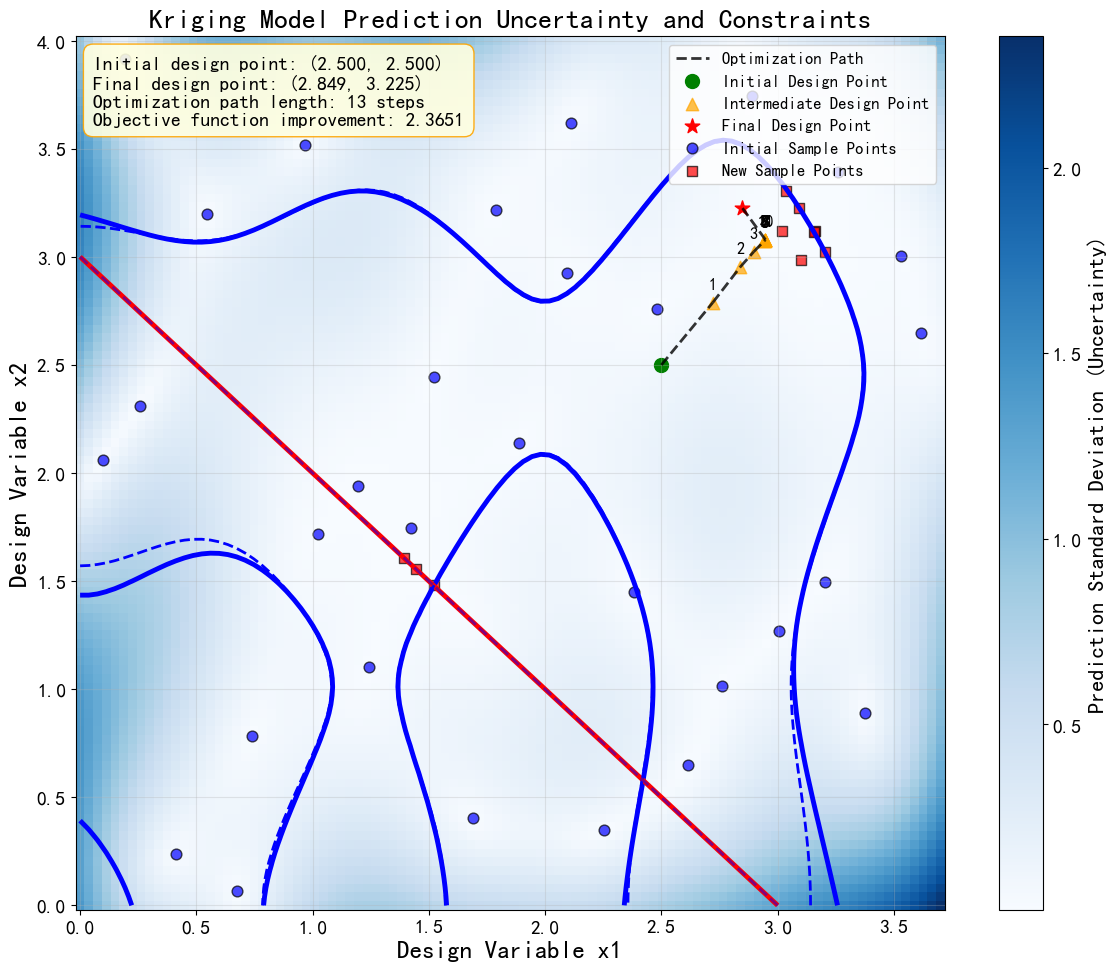

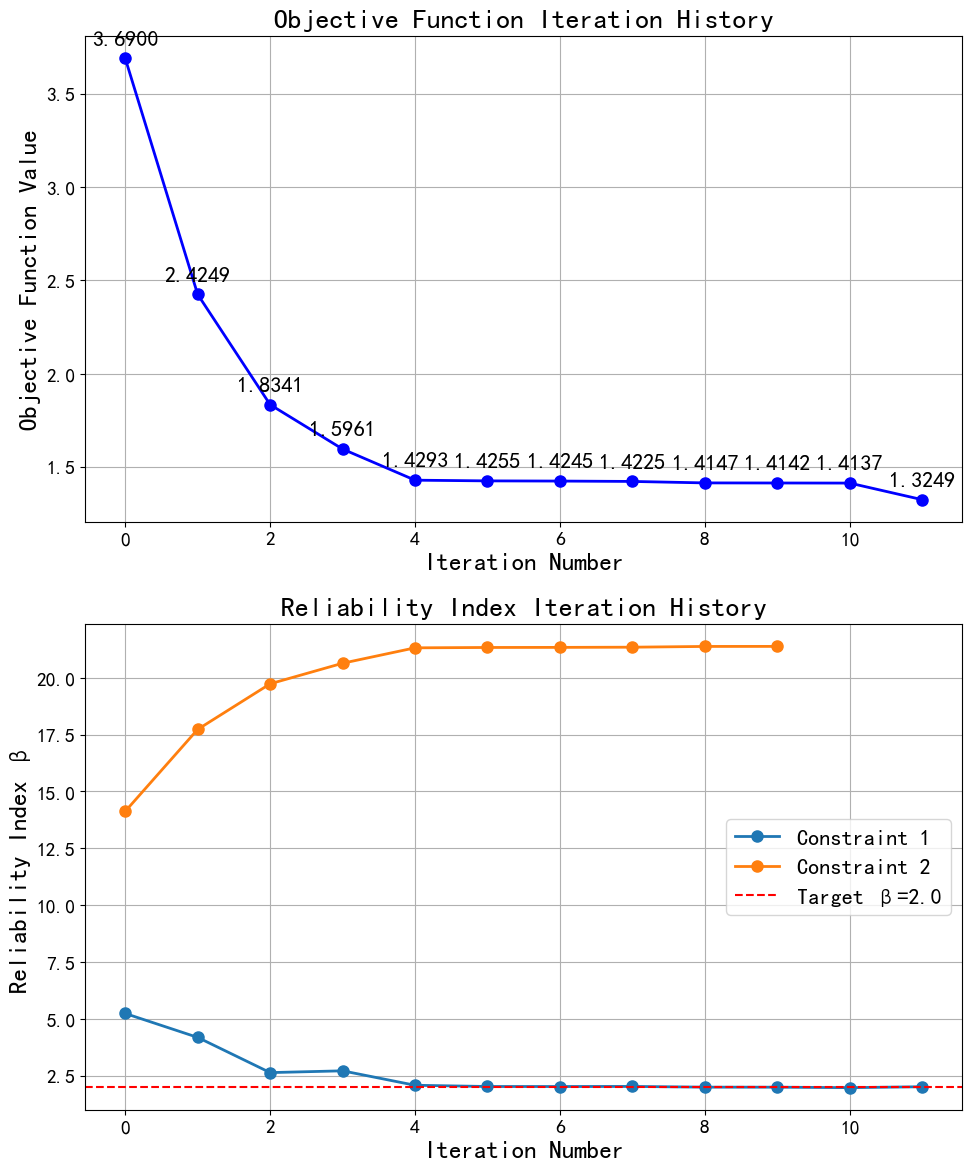

AMV method completed, reliability index β = 2.0536, constraint error = 0.001364
AMV method completed, reliability index β = 21.7153, constraint error = 0.003002

=== Optimization Results Summary ===
Final optimized design point: [2.84864833 3.22535931]
Final objective function value: 1.324867865754955
AMV method reliability indices: [2.053608635507722, 21.715291403473067]
MCS method reliability indices: [2.01676541        inf]
MCS method failure probabilities: [0.02406 0.     ]
Reliability requirements met: True
Beta target history: [[5.2381088788063535, 14.128356090321747], [4.186037093372594, 17.731531830525228], [2.63810813791757, 19.735600959076912], [2.7165595893845444, 20.639786244711203], [2.081546564077548, 21.317713641851167], [2.027326882159944, 21.333437718699344], [2.026097800044207, 21.337410433192566], [2.0302217772825504, 21.345859967114215], [1.9985609536193452, 21.378950439240512], [1.996906719703465, 21.380863619218598], array([1.97630715,        inf]), array([2.01676

C:\Users\syc\AppData\Local\Temp\ipykernel_42124\1594438170.py:226: RuntimeWarning: invalid value encountered in scalar divide
  rel_diff = diff / final_beta_values[i] * 100


In [49]:
def main():
    # Set random seed
    np.random.seed(1)

    # Parameter settings
    beta_target = 2.0
    initial_design = np.array([2.5, 2.5])
    bounds = np.array([[0.0, 3.7], [0.0, 4.0]])
    max_iter = 10
    max_total_samples = 100  # Set maximum total sample size
    initial_samples_num = 30  # Number of initial samples

    # Initialize samples
    X_initial = initial_samples(bounds, initial_samples_num)
    Y_samples = np.array([constraint_functions(x) for x in X_initial])

    print(f"Number of initial samples: {len(X_initial)}")
    # Set random seed for reproducibility
    seed_value = 13
    np.random.seed(seed_value)

    # Custom optimizer function, set maxiter
    def custom_optimizer(obj_func, initial_theta, bounds):
        # Call fmin_l_bfgs_b and set maxiter
        theta_opt, func_min, _ = fmin_l_bfgs_b(
            obj_func,
            initial_theta,
            bounds=bounds,
            maxiter=1000,  # Set maximum number of iterations
            factr=1e-6  # Set stopping condition
        )
        return theta_opt, func_min

    # Build initial Kriging models
    kriging_models = []
    for i in range(Y_samples.shape[1]):
        kernel = C(1000.0, (1e-1, 1e8)) * RBF(
            length_scale=np.ones(X_initial.shape[1]),
            length_scale_bounds=[(1e-3, 1e6)] * X_initial.shape[1]
        )
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=50,
            optimizer=custom_optimizer,  # Use custom optimizer
            alpha=1e-6,
            normalize_y=False,
            random_state=seed_value
        )
        gpr.fit(X_initial, Y_samples[:, i])
        kriging_models.append(gpr)

    # Store history data for visualization
    design_history = [initial_design.copy()]
    objective_history = [objective_function(initial_design)]
    mpp_history = []
    beta_history = []

    # Track all sample points - initialize with initial samples
    X_all_samples = X_initial.copy()

    # Iterative optimization
    design_point = initial_design.copy()
    for iteration in range(max_iter):
        print(f"Iteration: {iteration+1}")

        # MPP Calculation
        mpp_points = []
        beta_values = []
        for i, model in enumerate(kriging_models):
            mpp, beta = find_mpp_improved(model, design_point, np.array([0.1, 0.1]), beta_target)
            mpp_points.append(mpp)
            beta_values.append(beta)

        # Store MPP and beta history
        mpp_history.append(mpp_points)
        beta_history.append(beta_values)

        # Feasibility Check - update call, passing mpp_points
        feasibility_status = check_feasibility(beta_values, beta_target, kriging_models, design_point, mpp_points)
        print(f"Feasibility status: {feasibility_status}")

        # Use select_new_samples function to add new samples
        new_samples = select_new_samples(
            feasibility_status,
            kriging_models,
            bounds,
            design_point,
            beta_target,
            num_samples=1,  # Baseline sample count per constraint
            max_total_samples=max_total_samples  # Maximum total sample size limit
        )

        # If there are new samples, update models
        if len(new_samples) > 0:
            print(f"Added {len(new_samples)} new sample points")
            new_Y = np.array([constraint_functions(x) for x in new_samples])

            # Update samples and models
            X_all_samples = np.vstack((X_all_samples, new_samples))  # Update all sample points
            Y_samples = np.vstack((Y_samples, new_Y))  # Update Y_samples with constraint values of all samples

            # Re-fit Kriging models
            for i in range(len(kriging_models)):
                length_scale = np.ones(X_initial.shape[1])
                kernel = C(1000.0, (1e-1, 1e8)) * RBF(length_scale, [(1e-3, 1e6)] * X_initial.shape[1])
                gpr = GaussianProcessRegressor(
                    kernel=kernel,
                    n_restarts_optimizer=50, # Increased restart count
                    optimizer=custom_optimizer,
                    alpha=1e-6,
                    normalize_y=False,
                    random_state=seed_value
                )
                gpr.fit(X_all_samples, Y_samples[:, i])
                kriging_models[i] = gpr

            # Print sample count information for debugging
            print(f"Sample update: X samples = {X_all_samples.shape[0]}, Y samples = {Y_samples.shape[0]}")
        # Use two-stage optimization strategy - integrate MCS reliability analysis
        print("Starting two-stage optimization...")
        new_design_point, is_feasible = two_stage_optimization(
            design_point, kriging_models, bounds, beta_target, use_mcs=True)

        # Store design point and objective function history
        design_history.append(new_design_point.copy())
        objective_history.append(objective_function(new_design_point))

        # Use robust convergence check
        if iteration > 0:
            converged, reliability_satisfied, status = check_robust_convergence(
                new_design_point, design_point,
                objective_history[-1], objective_history[-2],
                beta_values, beta_history[-1],
                beta_target
            )

            print("Robust convergence check results:")
            print(f"Design point change: {status['design_change']:.6f}, Converged: {status['design_converged']}")
            print(f"Objective function relative change: {status['obj_rel_change']:.6f}, Converged: {status['obj_converged']}")
            print(f"Reliability index changes: {status['beta_changes']}, Converged: {status['all_beta_converged']}")
            print(f"Reliability requirement met: {status['beta_satisfied']}")

            if converged and not reliability_satisfied:
                print("Optimization has converged but reliability requirements are not met, initiating MCS-guided optimization...")
                final_design, final_obj, final_mcs_beta, mcs_history = mcs_guided_optimization(
                    new_design_point, kriging_models, bounds, beta_target)

                # Update design point and history
                if all(beta >= beta_target for beta in final_mcs_beta):
                    print("MCS-guided optimization successfully found a design point meeting reliability requirements")
                    new_design_point = final_design
                    # Add to history
                    design_history.extend(mcs_history['design_points'][1:])
                    objective_history.extend(mcs_history['objectives'][1:])
                    # Update other history as needed
            if converged and reliability_satisfied:
                print("All constraints are feasible and design point has converged, optimization finished.")
                break
        design_point = new_design_point
        print(f"Current design point: {design_point}, Objective function value: {objective_function(design_point)}")

    # Display optimization history and results using new visualization function
    print("\n=== Plotting Optimization History and Results ===")

    # Ensure history data arrays have consistent lengths
    if len(objective_history) != len(beta_history):
        print(f"Warning: Objective history length ({len(objective_history)}) does not match reliability index history length ({len(beta_history)})")

        # If lengths are inconsistent, truncate to the shorter length
        min_length = min(len(objective_history), len(beta_history))
        objective_history = objective_history[:min_length]
        beta_history = beta_history[:min_length]
        print(f"Both history data truncated to the same length: {min_length}")

    # Calculate final reliability indices using Monte Carlo simulation
    print("\nCalculating final reliability indices using Monte Carlo simulation...")
    final_beta_values, final_pf_values, final_is_feasible = mcs_reliability_analysis(
        design_point, kriging_models, num_samples=100000, beta_target=beta_target)

    # Add final results to history
    design_history.append(design_point)
    objective_history.append(objective_function(design_point))
    beta_history.append(final_beta_values)

    # If MCS shows reliability requirements are not met, attempt final MCS-guided optimization
    if not final_is_feasible:
        print("\nMCS indicates the final design point does not meet reliability requirements, initiating MCS-guided optimization...")
        final_design, final_obj, final_mcs_beta, mcs_history = mcs_guided_optimization(
            design_point, kriging_models, bounds, beta_target)

        # If MCS-guided optimization is successful, update final results
        if all(beta >= beta_target for beta in final_mcs_beta):
            print("MCS-guided optimization successfully found a design point meeting reliability requirements")
            design_point = final_design
            final_beta_values = final_mcs_beta
            final_is_feasible = True

            # Update history
            design_history.append(design_point)
            objective_history.append(objective_function(design_point))
            beta_history.append(final_beta_values)
    # Plot final results - passing initial and all sample points
    plot_final_results(kriging_models, design_history, bounds, X_initial, X_all_samples)
    plot_iteration_history(objective_history, beta_history, beta_target)
    # Also calculate AMV reliability indices for comparison
    final_mpp_points = []
    amv_beta_values = []
    for i, model in enumerate(kriging_models):
        mpp, beta = find_mpp_improved(model, design_point, np.array([0.1, 0.1]), beta_target)
        final_mpp_points.append(mpp)
        amv_beta_values.append(beta)

    print("\n=== Optimization Results Summary ===")
    print(f"Final optimized design point: {design_point}")
    print(f"Final objective function value: {objective_function(design_point)}")
    print(f"AMV method reliability indices: {amv_beta_values}")
    print(f"MCS method reliability indices: {final_beta_values}")
    print(f"MCS method failure probabilities: {final_pf_values}")
    print(f"Reliability requirements met: {final_is_feasible}")
    print(f"Beta target history: {beta_history}")

    # Compare AMV and MCS methods
    print("\n=== AMV vs. MCS Method Comparison ===")
    for i in range(len(kriging_models)):
        diff = abs(amv_beta_values[i] - final_beta_values[i])
        rel_diff = diff / final_beta_values[i] * 100
        print(f"Constraint {i+1}: AMV Beta = {amv_beta_values[i]:.4f}, MCS Beta = {final_beta_values[i]:.4f}")
        print(f"Difference: {diff:.4f} (Relative difference: {rel_diff:.2f}%)")

    # Return final results
    return design_point, objective_function(design_point), final_beta_values, final_pf_values, kriging_models, bounds

# Execute the main function
main_results = main()